The purpose of this document is to use scheduled sampling for training (as opposed to teacher-forcing).

In [1]:
import torch, math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from ipywidgets import IntProgress
from IPython.display import display

### Various Preprocessing methods

In [3]:
theta_Tr = np.zeros(1)
theta_Te = np.zeros(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_to_save_model = 'scheduled_sampling_save_model/'

def preproceess_data(NUM_DATA, sanity_check = False):
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('10pendula.npz')
    else:
        data = np.load('10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]

def preproceess_data_standardize(NUM_DATA, sanity_check = False):
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('10pendula.npz')
    else:
        data = np.load('10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]
    
    # 3. standardize the data by viewing position and velocity as 2 features
    pos_tr = theta_Tr[:,:,::2]
    vel_tr = theta_Tr[:,:,1::2]
    
    mean_std_dict = {
        "mean_pos": np.mean(pos_tr),
        "std_pos": np.std(pos_tr),
        "mean_vel": np.mean(vel_tr),
        "std_vel": np.std(vel_tr)
    }
    
    theta_Tr[:,:,::2] = (theta_Tr[:,:,::2]  - mean_std_dict["mean_pos"]) / mean_std_dict["std_pos"] # position
    theta_Tr[:,:,1::2] = (theta_Tr[:,:,1::2]  - mean_std_dict["mean_vel"]) / mean_std_dict["std_vel"] # velocity
    
    theta_Te[:,:,::2] = (theta_Te[:,:,::2]  - mean_std_dict["mean_pos"]) / mean_std_dict["std_pos"] # position
    theta_Te[:,:,1::2] = (theta_Te[:,:,1::2]  - mean_std_dict["mean_vel"]) / mean_std_dict["std_vel"] # velocity
    
    return mean_std_dict

def preproceess_data_normalize(NUM_DATA, sanity_check = False):
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('10pendula.npz')
    else:
        data = np.load('10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]
    
    # 3. NORMALIZE the data by viewing position and velocity as 2 features
    pos_tr = theta_Tr[:,:,::2]
    vel_tr = theta_Tr[:,:,1::2]
    
    min_max_dict = {
        "min_pos": np.min(pos_tr),
        "max_pos": np.max(pos_tr),
        "min_vel": np.min(vel_tr),
        "max_vel": np.max(vel_tr)
    }
    
    theta_Tr[:,:,::2] = (theta_Tr[:,:,::2]  - min_max_dict["min_pos"]) / (min_max_dict["max_pos"] - min_max_dict["min_pos"]) # position
    theta_Tr[:,:,1::2] = (theta_Tr[:,:,1::2]  - min_max_dict["min_vel"]) / (min_max_dict["max_vel"] - min_max_dict["min_vel"]) # velocity
    
    theta_Te[:,:,::2] = (theta_Te[:,:,::2]  - min_max_dict["min_pos"]) / (min_max_dict["max_pos"] - min_max_dict["min_pos"]) # position
    theta_Te[:,:,1::2] = (theta_Te[:,:,1::2]  - min_max_dict["min_vel"]) / (min_max_dict["max_vel"] - min_max_dict["min_vel"]) # velocity
    
    return min_max_dict

### Positional Encoding and the Model

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, d_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model) # 1000^(2i/d_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/d_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/d_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        token_embedding = token_embedding.to(device)
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
    
class Transformer(nn.Module):
    # d_model : number of features
    def __init__(self,feature_size=20,num_layers=3,dropout=0):
        super(Transformer, self).__init__()
        self.positional_encoder = PositionalEncoding(d_model=feature_size, dropout=dropout, max_len=5000)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=5, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, device):
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        output = self.positional_encoder(src)
        output = self.transformer_encoder(output,mask)
        output = self.decoder(output)
        return output

### Teacher-Forcing and Scheduled Sampling

In [5]:
def train_transformer_teacher_forcing(EPOCH = 300):
    model = Transformer().double().to(device)
    model.train()  # turn on train mode

    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()
    best_model = ""
    min_train_loss = float('inf')
    
    for epoch in range(EPOCH + 1):
        train_loss = 0
        for i in range(theta_Tr.shape[0]):
            # iterate through each training example
            cur_theta = theta_Tr[i] # check dim later; not sure about batch
            optimizer.zero_grad()
            
            src = cur_theta[:-1,:] # input is the vector except for the last time step's
            src = torch.from_numpy(np.expand_dims(src, axis=1)).double() # torch.Size([59, 1, 20]) as 1 is batchsize
            target = cur_theta[1:,:] # this is the ground truth output, shift by one according to Medium blog post
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double() # torch.Size([59, 1, 20])
            
            prediction = model(src, device)
            loss = criterion(prediction, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()
            
        if train_loss < min_train_loss:
            torch.save(model.state_dict(), path_to_save_model + f"best_train.pth")
            torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer.pth")
            min_train_loss = train_loss
            
        if epoch % (np.ceil(EPOCH / 10)) == 0:
            print(f"Epoch: {epoch}, Average training loss: {train_loss / theta_Tr.shape[0]}")

In [6]:
def train_transformer_scheduled_sampling(EPOCH = 500, scheduled_samp_k = 40, model_thresh = 300):
    """
    Since it is harder to achieve a low loss for scheduled sampling, we will record a best model (.pth)
    that only comes after epoch model_thresh.
    """
    model = Transformer().double().to(device)
    model.train()  # turn on train mode

    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()
    best_model = ""
    min_train_loss = float('inf') # global minimum loss
    min_train_loss_after_thresh = float('inf') # minimum loss after the threshold
    global_min_epoch = -1 # the epoch that achieves min_train_loss
    after_thresh_min_epoch = -1 # the epoch that achieves min_train_loss_after_thresh
    train_losses = np.zeros(EPOCH) # records all losses
    
    progress_bar = IntProgress(min=0, max=EPOCH) # instantiate the progress bar
    display(progress_bar)
    
    for epoch in range(EPOCH + 1):
        train_loss = 0
        for i in range(theta_Tr.shape[0]):
            # iterate through each training example
            cur_theta = theta_Tr[i] # check dim later; not sure about batch
            optimizer.zero_grad()
            
            src = cur_theta[:-1,:] # input is the vector except for the last time step's
            src = torch.from_numpy(np.expand_dims(src, axis=1)).double().to(device) # torch.Size([59, 1, 20]) as 1 is batchsize
            target = cur_theta[1:,:] # this is the ground truth output, shift by one according to Medium blog post
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double().to(device) # torch.Size([59, 1, 20])
            
            sampled_src = src[:1, :, :] #t0 torch.Size([1, 1, 20]) the initial condition which TF will know even in inference
            
            ####### UP TO THIS POINT, EXACTLY THE SAME AS TEACHER FORCING #######
            
            for j in range(59): # iterate through the entire forecast window
                prediction = model(sampled_src, device) # torch.Size([j + 1, 1, 20])
                
                if j == 58: # no need to append next timestep since we have finished predicting
                    continue 
                    
                flag_feed_true = False # whether we will feed the true value of next timestep, or TF will use what it predicts
                
                # 1. flip coin to decide flag_feed_true
                # using inverse sigmoid function as visualized below, decreases over epochs
                prob_feed_true = scheduled_samp_k/(scheduled_samp_k+np.exp(epoch/scheduled_samp_k)) 
                coin = np.random.rand() # uniformly [0, 1)
                if coin < prob_feed_true:
                    flag_feed_true = True
                else:
                    flag_feed_true = False
                
                if flag_feed_true: # feed the true value
                    sampled_src = torch.cat((sampled_src.detach(), src[j+1, :, :].unsqueeze(0).detach())) 
                else: # use whatever the model predictede
                    predicted = prediction[-1,:,:].unsqueeze(0)
                    sampled_src = torch.cat((sampled_src.detach(), predicted.detach()))
            
            loss = criterion(prediction, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()
             
        if train_loss < min_train_loss:
            torch.save(model.state_dict(), path_to_save_model + f"best_train_global.pth")
            torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer_global.pth")
            min_train_loss = train_loss
            global_min_epoch = epoch
        if epoch >= model_thresh and train_loss < min_train_loss_after_thresh:
            torch.save(model.state_dict(), path_to_save_model + f"best_train_after_thresh.pth")
            torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer_after_thresh.pth")
            min_train_loss_after_thresh = train_loss
            after_thresh_min_epoch = epoch
        train_losses[epoch] = train_loss
        

        if epoch % (np.ceil(EPOCH / 10)) == 0:
            print(f"Epoch: {epoch}, Average training loss: {train_loss / theta_Tr.shape[0]}")
            
        progress_bar.value += 1
    
    print("The epoch that achieves global minimum loss is {}".format(global_min_epoch))
    print("The epoch that achieves minimum loss after epoch {} is {}".format(model_thresh, after_thresh_min_epoch))
    
    return train_losses

### Inverse Sigmoid: Visualize affects by EPOCH and k 

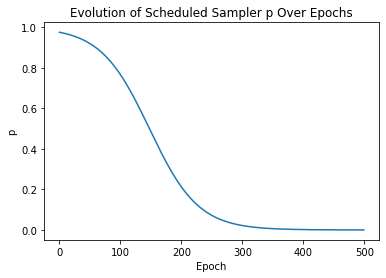

In [7]:
# the plotted function is the probability we will sample true values over time (i.e. over epoch)
k = 40
EPOCH = 500
x = np.arange(EPOCH)
y = k/(k+np.exp(x/k))
plt.plot(y)
plt.xlabel("Epoch")
plt.ylabel("p")
plt.title('Evolution of Scheduled Sampler p Over Epochs')
plt.savefig('scheduled_sampler.png', dpi=300)

### Inference and Visualization Methods

In [24]:
def inference_one_input():
    """
    As opposed to the cheating version of inference, the Transformer will only know about the t0 for input;
    then each time the transformer predicts the next timestamp, this output is recycled to be the input
    for the next timestamp's input.
    """ 
    model = Transformer().double().to(device)
    # model.load_state_dict(torch.load(path_to_save_model+"best_train.pth"))
    model.load_state_dict(torch.load(path_to_save_model+"best_train_after_thresh.pth"))
    criterion = torch.nn.MSELoss()
    
    total_loss = 0
    loss_array = np.zeros(theta_Te.shape[0])
    
    with torch.no_grad():
        for i in range(theta_Te.shape[0]):
            cur_theta = theta_Te[i]
            src = cur_theta[0,:] # t0
            src = torch.from_numpy(np.expand_dims(src, axis=[0,1])).double().to(device) # torch.Size([1, 1, 20]) as 1 is batchsize
            
            target = cur_theta[1:,:] # shift by one according to Medium # t1 to 59
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double().to(device)
            
            all_predictions = []
            next_input_model = src
            
            for j in range(59): # iterate through the entire forecast window
                prediction = model(next_input_model, device) # torch.Size([j, 1, 20])
                
                if all_predictions == []:
                    all_predictions = prediction # 1, 1, 20
                else:
                    all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0)))
                    
                next_input_model = all_predictions
            
            cur_loss = criterion(all_predictions, target).item()
            total_loss += cur_loss
            loss_array[i] = cur_loss
             
    return total_loss / theta_Te.shape[0], loss_array

In [25]:
def visualize_test(loss_array, average_testing_loss, want_worst = False, want_avg = False):
    """
    If want worst, will plot the test with the highest loss
    If want avg, will plot the test with the loss closest to the average
    """
    assert (want_worst + want_avg) == 1 # can only visualize one
    
    # 1. first locate the id that we want to visualize
    viz_id = -1
    if want_worst:
        viz_id = np.argmax(loss_array)
    elif want_avg:
        viz_id = np.argmin(np.abs(loss_array - average_testing_loss))
        
    # 2. rerun model for this test
    model = Transformer().double().to(device)
    # model.load_state_dict(torch.load(path_to_save_model+"best_train.pth"))
    model.load_state_dict(torch.load(path_to_save_model+"best_train_after_thresh.pth"))
    criterion = torch.nn.MSELoss()

    all_predictions = []
    cur_loss = 0
    
    with torch.no_grad():
        cur_theta = theta_Te[viz_id]
        src = cur_theta[0,:] # t0
        src = torch.from_numpy(np.expand_dims(src, axis=[0,1])).double().to(device) # torch.Size([1, 1, 20]) as 1 is batchsize
        target = cur_theta[1:,:] # shift by one according to Medium # t1 to 59
        target = torch.from_numpy(np.expand_dims(target, axis=1)).double().to(device)
        next_input_model = src
        
        for j in range(59): # iterate through the entire forecast window
            prediction = model(next_input_model, device) # torch.Size([j, 1, 20])
            if all_predictions == []:
                all_predictions = prediction # 1, 1, 20
            else:
                all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0)))
            next_input_model = all_predictions
            
        cur_loss = criterion(all_predictions, target).item()
        
    print("Average testing loss is: " + str(average_testing_loss))
    print("Visualizing test with loss: " + str(cur_loss))
    target = theta_Te[viz_id, 1:]
    prediction = torch.squeeze(all_predictions).cpu()
    
    # 3. first plot position
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 200, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 # since we only want the position features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(prediction[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Position')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Position Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. then plot velocity
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 + 1 # since we only want the velocity features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(prediction[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Velocity')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Velocity Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Compare Teacher-Forcing and Scheduled Sampling

In [11]:
mean_std_dict = preproceess_data_standardize(NUM_DATA = 500, sanity_check = False)

In [50]:
# We choose normalized data over standardized; not a final choice tho

train_losses = train_transformer_scheduled_sampling(EPOCH = 500, scheduled_samp_k = 40, model_thresh = 300)

IntProgress(value=0, max=500)

Epoch: 0, Average training loss: 0.584906892930257
Epoch: 50, Average training loss: 0.07519553835704681
Epoch: 100, Average training loss: 0.06770820509992138
Epoch: 150, Average training loss: 0.07833948320027599
Epoch: 200, Average training loss: 0.12300310220727212
Epoch: 250, Average training loss: 0.20421140105106758
Epoch: 300, Average training loss: 0.22055145985890218
Epoch: 350, Average training loss: 0.20455927250975914
Epoch: 400, Average training loss: 0.141866438388971
Epoch: 450, Average training loss: 0.14879783580489453
Epoch: 500, Average training loss: 0.1448600243779417
The epoch that achieves global minimum loss is 103
The epoch that achieves minimum loss after epoch 300 is 480


In [ ]:
plt.plot(np.arange(500), train_losses)

Average testing loss is: 0.884068390929055
Visualizing test with loss: 0.8778411747113305


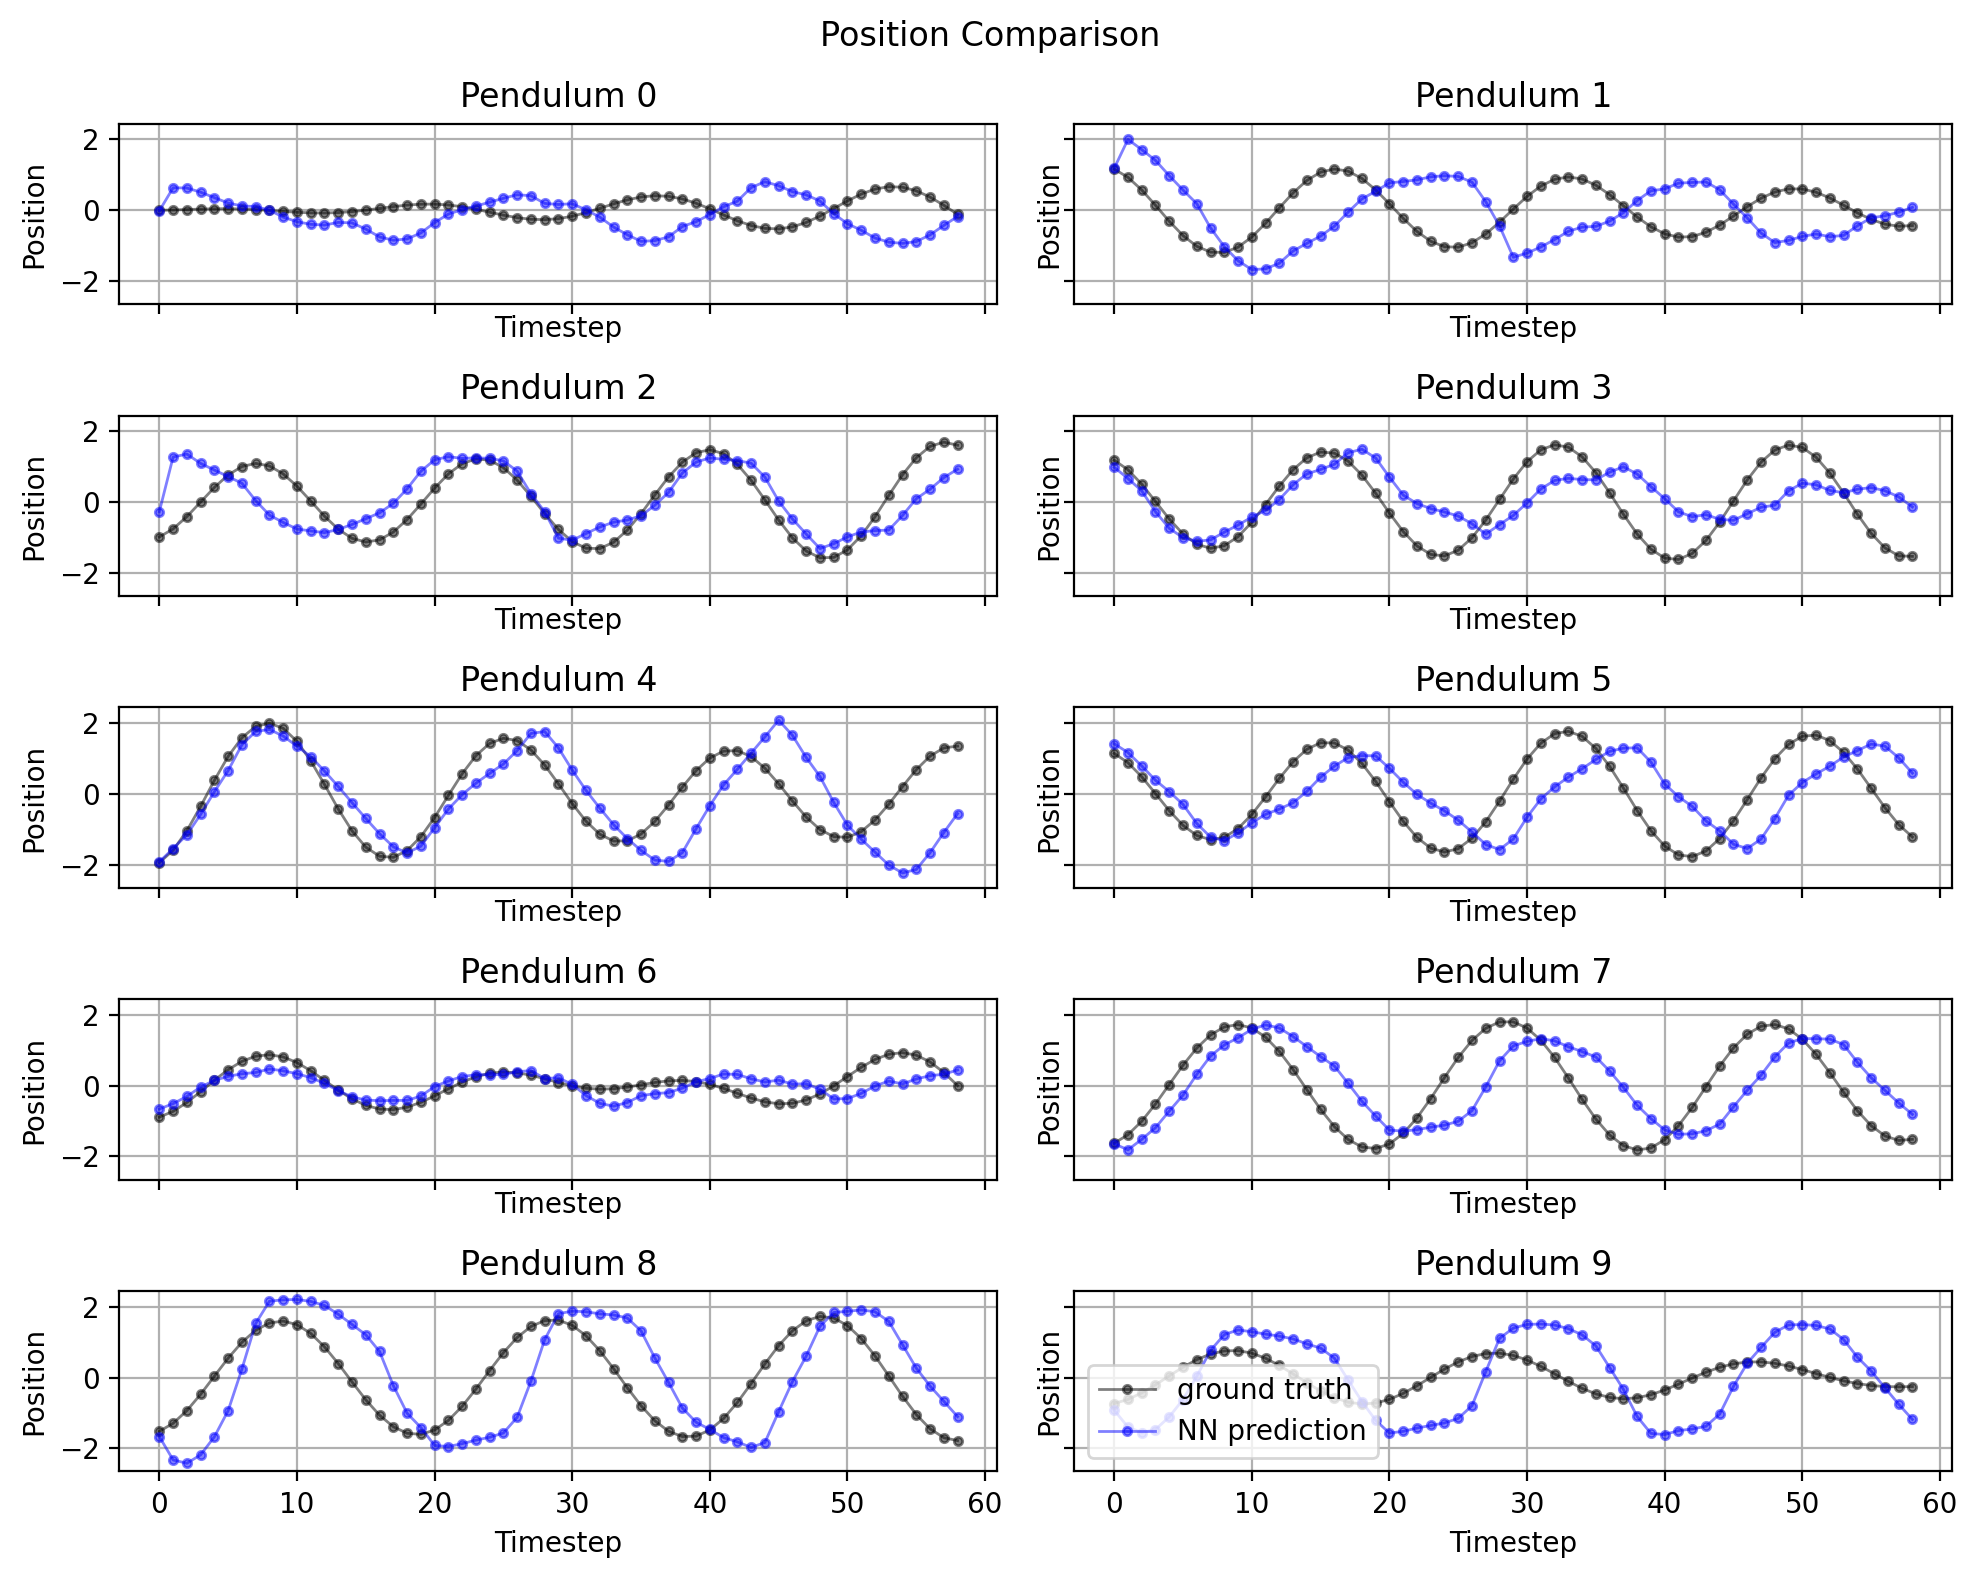

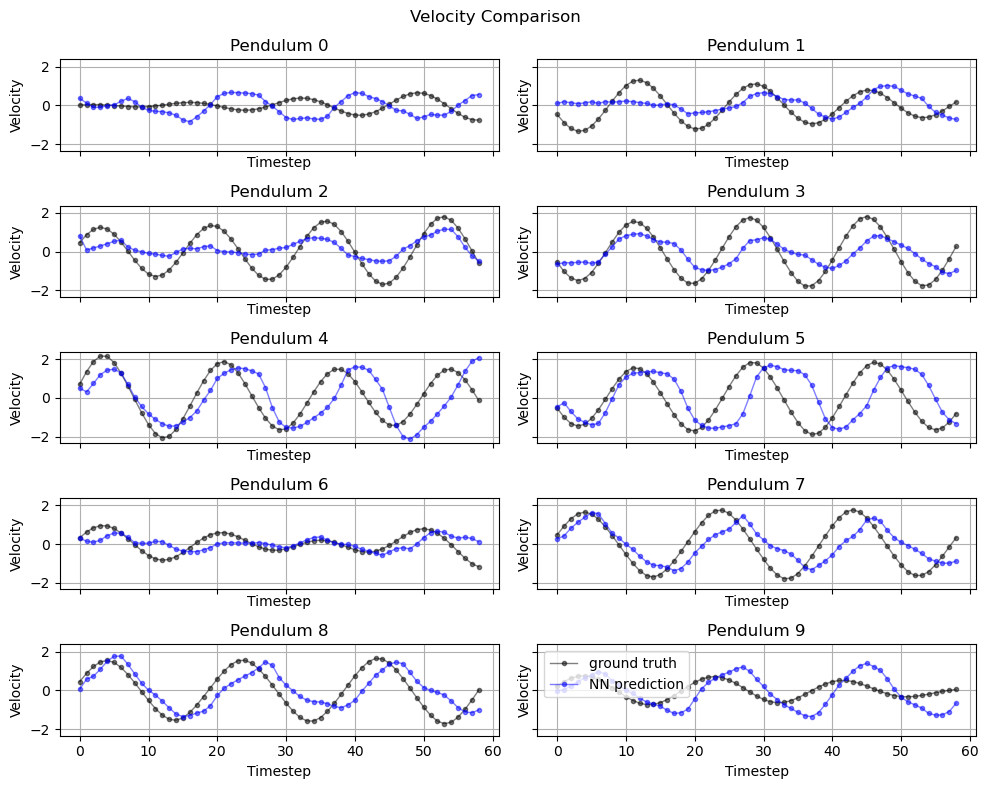

In [28]:
average_testing_loss, loss_array = inference_one_input()
visualize_test(loss_array, average_testing_loss, want_worst = False, want_avg = True)